In [110]:
#pip install scikit-surprise

### Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

## Reading Data:-

In [5]:
df = pd.read_excel('/content/HFN Portal.xlsx')
df.head()

,Order,Buyer Name,PinCode,Crop Name,Qty,Crop ID,Created Date
0,230614,Monika Khatri,160055,Carrot,1,2856,2021-05-09
1,230561,Lovely walia,160071,Mango,2,2896,2021-04-29
2,230614,Monika Khatri,160055,Coriander Seeds,2,2870,2021-05-09
3,230561,Lovely walia,160071,Honey,1,2895,2021-04-29
4,230561,Lovely walia,160071,Coriander Seeds,1,2870,2021-04-29


In [6]:
df.shape

(3402, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3402 entries, 0 to 3401
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order         3402 non-null   int64         
 1   Buyer Name    3402 non-null   object        
 2   PinCode       3402 non-null   int64         
 3   Crop Name     3402 non-null   object        
 4   Qty           3402 non-null   int64         
 5   Crop ID       3402 non-null   int64         
 6   Created Date  3402 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 186.2+ KB


In [8]:
df.describe()

,Order,PinCode,Qty,Crop ID
count,3402.000000,3402.000000,3402.000000,3402.000000
mean,231287.301293,407955.083186,1.390653,2919.013815
std,482.546955,192812.680655,1.299789,107.595014
min,230521.000000,110001.000000,1.000000,2727.000000
25%,230798.250000,201002.000000,1.000000,2822.000000
50%,231267.000000,500048.000000,1.000000,2903.000000
75%,231715.000000,560055.000000,1.000000,3031.000000
max,232103.000000,852212.000000,32.000000,3067.000000


In [9]:
start_date = min(df['Created Date'])
end_date = max(df['Created Date'])
print('Dataset is from {} to {}'.format(start_date,end_date))     # i.e. data is from 13 April to 5 July

Dataset is from 2021-04-13 00:00:00 to 2021-07-05 00:00:00


### Encoding Buyer name to category type Buyer ID

In [10]:
df['Buyer ID'] = df['Buyer Name'].astype('category')
df['Buyer ID'] = df['Buyer ID'].cat.codes  
df.head(3)

,Order,Buyer Name,PinCode,Crop Name,Qty,Crop ID,Created Date,Buyer ID
0,230614,Monika Khatri,160055,Carrot,1,2856,2021-05-09,291
1,230561,Lovely walia,160071,Mango,2,2896,2021-04-29,259
2,230614,Monika Khatri,160055,Coriander Seeds,2,2870,2021-05-09,291


In [109]:
print("Total data: ")
print("-"*30)
print("\nNumber of unique buyers :", df['Buyer ID'].nunique())
print("Number of unique crops   :", df['Crop ID'].nunique())
#print("Number of unique pincodes :", df['PinCode'].nunique())

Total data: 
------------------------------

Number of unique buyers : 652
Number of unique crops   : 159


# Exploratory Data Analysis:-


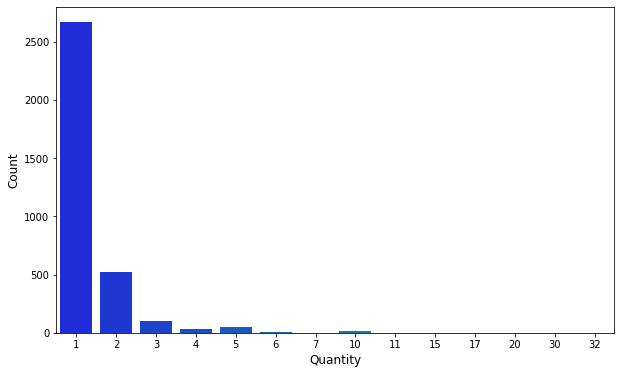

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(x='Qty', data=df, palette='winter')
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [13]:
df1=pd.DataFrame({'Total Crop Count':df.groupby('Crop ID').count()['Qty'], 'Mean Crop Count':df.groupby('Crop ID').mean()['Qty']})
df1

,Total Crop Count,Mean Crop Count
Crop ID,,
2727,16,1.250000
2728,25,1.360000
2729,26,1.230769
2730,11,1.545455
2731,5,1.200000
...,...,...
3058,90,1.755556
3059,17,2.294118
3065,12,1.000000


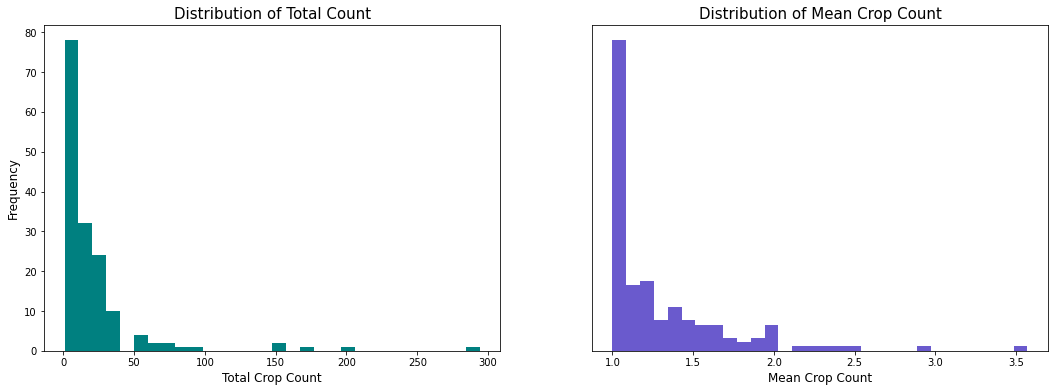

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Total Crop Count',data=df1,bins=30,color='teal')
plt.title('Distribution of Total Count', fontsize=15)
plt.xlabel('Total Crop Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Crop Count',data=df1,bins=30, color='slateblue')
plt.title('Distribution of Mean Crop Count', fontsize=15)
plt.xlabel('Mean Crop Count', fontsize=12)
plt.yticks([])
plt.show()

# Recommender Systems:-

## **Popularity-Based Recommender System**

Weighted Rating (WR) =  (v/v+m)R+(m/v+m)C  

v: total count of the product

m: the minimum count considered to be in top recommendations

R: the average count of the product

C: the mean count across the whole data

In [96]:
def product_score(x):
    v=x['Total Crop Count']
    m=df1['Total Crop Count'].quantile(q=0.9)
    R=x['Mean Crop Count']
    C=df1['Mean Crop Count'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [102]:
m=df1['Total Crop Count'].mean()
m

21.39622641509434

In [103]:
df1['Score']=df1.apply(product_score, axis=1)
df1.head()

,Total Crop Count,Mean Crop Count,Score
Crop ID,,,
2727,16,1.250000,1.277535
2728,25,1.360000,1.317252
2729,26,1.230769,1.265420
2730,11,1.545455,1.346671
2731,5,1.200000,1.278765


In [104]:
df_highscore=df1.sort_values(by='Score', ascending=False).head(20)
df_highscore.head()

,Total Crop Count,Mean Crop Count,Score
Crop ID,,,
3066,62,2.193548,1.849869
2897,33,2.393939,1.802632
3031,170,1.870588,1.764360
2984,52,1.980769,1.688743
2990,7,3.571429,1.644153


*RESULT*

In [18]:
df_highscore.index

Int64Index([3066, 2897, 3031, 2984, 2990, 2818, 2843, 3058, 3059, 2920, 2822,
            2870, 2898, 2782, 2744, 2825, 2884, 2820, 2942, 2821],
           dtype='int64', name='Crop ID')

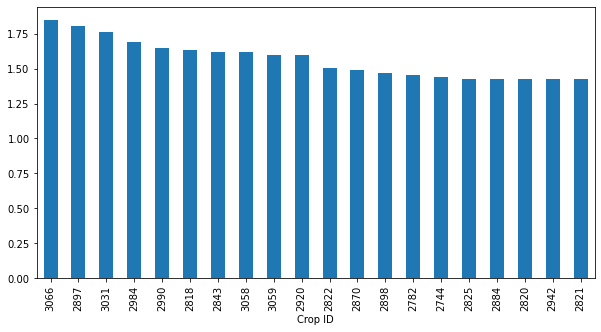

In [58]:
#Top 30 Product that would be recommended.
df_highscore['Score'].plot(kind='bar', figsize =(10,5))

**This recommendation will be same for all the buyers!**     

We should keep in mind that this popularity-based recommender provides a general chart of recommended crops to all the buyers, regardless of the buyer's personal taste. It is not sensitive to the seasonality interests of a particular buyer, and it does not give personalized recommendations based on the buyers.

## **Collaborative Recommender System**

Collaborative Filtering matches persons with similar interests and provides recommendations based on this matching. It is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

Surprise library is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Here we use the Surprise library that uses extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise Root Mean Square Error (RMSE) that is measured by Kfold Cross Validation and give great recommendations.

#### SVD: Matrix Factorization Based Algorithm

In [19]:
svd = SVD()

In [20]:
reader = Reader()

In [21]:
data = Dataset.load_from_df(df[['Buyer ID', 'Crop ID', 'Qty']], reader)

In [22]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8079  1.2606  1.2197  1.2929  0.9382  1.1038  0.1943  
MAE (testset)     0.4055  0.4346  0.4921  0.4584  0.4044  0.4390  0.0333  
Fit time          0.17    0.15    0.16    0.15    0.15    0.15    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'fit_time': (0.16558241844177246,
  0.14635848999023438,
  0.15942740440368652,
  0.15235447883605957,
  0.14974188804626465),
 'test_mae': array([0.40550031, 0.4345709 , 0.49210137, 0.45838493, 0.40437916]),
 'test_rmse': array([0.80787747, 1.2605859 , 1.21974744, 1.29287033, 0.93815539]),
 'test_time': (0.005652427673339844,
  0.012750625610351562,
  0.005834817886352539,
  0.005540132522583008,
  0.005457162857055664)}

In [23]:
trainset = data.build_full_trainset()

In [24]:
svd.fit(trainset)

In [25]:
svd.predict(uid='291', iid='2856', r_ui=None).est

1.3906525573192239

Our model predicts that Buyer ID of '291' will buy 1.39 quantity for productId of '2856'.

Cross-checking it for a prticular buyer from original dataset --

In [94]:
#df.loc[df['Crop ID']==3067]
#df.loc[df['Buyer ID']==0]

## **Model-based Collaborative Filtering (user-item interaction)**

These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top most items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [105]:
new_df1=df
ratings_matrix = new_df1.pivot_table(values='Qty', index='Buyer ID', columns='Crop ID', fill_value=0)
ratings_matrix.head()

Crop ID,2727,2728,2729,2730,2731,2732,2733,2734,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2751,2754,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2768,2769,2770,2773,2774,2775,2776,...,2898,2899,2900,2901,2902,2903,2909,2910,2916,2918,2920,2921,2931,2932,2933,2942,2943,2955,2963,2983,2984,2989,2990,2991,2998,2999,3010,3023,3031,3035,3036,3037,3046,3047,3048,3058,3059,3065,3066,3067
Buyer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,1,0,0.0,0,0,0,0
1,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0,1.0,0,0.0,0,0,0.0,0,0,0,0
2,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,5,0
3,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0,0
4,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,3,0,0.0,0,0,0,0


In [108]:
ratings_matrix.shape

(652, 159)

In [59]:
X = ratings_matrix.T

In [32]:
X1 = X

In [33]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(159, 10)

In [34]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(159, 159)

In [36]:
X.index[158]

3067

In [38]:
#Index # of product ID purchased by customer
i = 3067

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

158

Correlation for all crops with the crop purchased by this customer based on crops purchased by other customers who bought the same product

In [39]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(159,)

*RESULT*

In [63]:
Recommend = list(X.index[correlation_product_ID > 0.55])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

[2736, 2742, 2744, 2757, 2778, 2857, 2866, 2963, 2989, 2990, 2999]

Here are the top products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.

## **Hybrid Recommender System**

Now building a hybrid recommender that combines corrwith() method which computes the Pearson correlation coefficients with collaborative filtering.     

This is how it works:

Input: User ID and Product ID

Output: Similar products sorted on the basis of expected quantity bought by a particular user.

First, we create a pivot table which contains userIds as rows and productIds as columns.

In [106]:
matrix = df.pivot_table(values='Qty', index='Buyer ID', columns='Crop ID', aggfunc= 'sum', fill_value=0)
matrix.head()

Crop ID,2727,2728,2729,2730,2731,2732,2733,2734,2736,2737,2738,2739,2740,2741,2742,2743,2744,2745,2746,2747,2748,2751,2754,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2768,2769,2770,2773,2774,2775,2776,...,2898,2899,2900,2901,2902,2903,2909,2910,2916,2918,2920,2921,2931,2932,2933,2942,2943,2955,2963,2983,2984,2989,2990,2991,2998,2999,3010,3023,3031,3035,3036,3037,3046,3047,3048,3058,3059,3065,3066,3067
Buyer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0


In [107]:
matrix.shape

(652, 159)

Defining a function that takes in productId and useId as input and outputs top most similar products. For this purpose, corrwith() method is used to compute pairwise correlation between columns of dataFrame and Pearson correlation coefficients are calculated.

In [89]:
# Function that takes in Crop Id and Buyer Id as input and outputs top most similar products.

def hybrid_recommendations(userId, productId):
    
    # Get the Id of the top products that are correlated with the ProductId chosen by the user.
    top_= matrix.corrwith(matrix[productId]).sort_values(ascending=False).head(15)
    #print(top_)
    # Predict the quantity the user might give to these top most correlated products.
    est_quantity=[]
    for x in list(top_.index):
        if str(top_[x])!='nan':
            est_quantity.append(svd.predict(userId, iid=x, r_ui=None).est)
           
    return pd.DataFrame({'Crop ID':list(top_.index)[:len(est_quantity)], 'Score':est_quantity}).sort_values(by='Score', ascending=False).reset_index(drop=True)

*RESULT*

In [92]:
hybrid_recommendations(291, 2856)

,Crop ID,Score
0,2855,1.503891
1,2765,1.369292
2,2770,1.289434
3,2896,1.245390
4,2865,1.149641
5,2863,1.128722
6,2775,1.126053
7,2757,1.125376
8,2856,1.086378
9,2756,1.068643


Hybrid Recommendation: Function that takes in Crop Id and Buyer Id as input and outputs top most similar products.

In [86]:
#df.loc[df['Crop ID']==2856
#df.loc[df['Buyer ID']==291]


# Conclusion:-

We built three different recommendation systems based on different algorithms. They are as follows:

**Popularity-Based Recommender:** This system used the total quantity purchased and mean quantity to find the top productIds. The Weighted Rating System was used to calculate scores on which the sorting was finally performed.

**Collaborative Filtering:** It used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was about 1.39 and the engine predicted estimated ratings for a given user and product. And user-item interaction type of filtering uses existing user-item interactions to train a model to predict the top most items that a user might like the most. They have large coverage, even when working with large sparse matrices.

**Hybrid Engine:** It combined corrwith() method which computed the Pearson correlation coefficients with collaborative filtering. Our hybrid recommender took useId and productId as input and suggested top products that were similar to the input productId based on the estimated ratings that was internally calculated for the input userId. This Hybrid System took advantage of both Pearson method and Collaborative filtering and therefore made reliable predictions